# 프로젝트 12: 뉴스기사 요약해보기

---
## Step 0. 라이브러리 호출

In [1]:
!pip install summa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.3 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=cc20ccbf1211acd931daccfab095f3c7660bc2278dae89d08a2d27017ef1da95
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import tensorflow
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
import summa

print(nltk.__version__)
print(tensorflow.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3.7
2.9.2


---
## Step 1. 데이터 수집하기

데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [5]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


---
## Step 2. 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

In [6]:
print('Headlines 샘플의 수 :', len(data['headlines']))
print('Text 샘플의 수 :', len(data['text']))
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

Headlines 샘플의 수 : 98401
Text 샘플의 수 : 98401
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있다. 추출적 요약을 하는 경우에는 오직 text열만을 사용한다.

In [7]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


Null 값에 대한 처리를 위해 확인해보자

In [8]:
#데이터프레임에 Null 값이 있는지 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


Null 값은 없는 것으로 확인된다.

다음으로, 영어 문법에서 I am = I'm과 같은 축약을 정리하는 텍스트 정규화와 일반적으로 자주 등장하지만 자연어 처리에는 별 도움이 되지 않는 불용어를 제거하도록 한다.

In [9]:
#텍스트 정규화(text normalization) 
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
#불용어(stopwords) 제거
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

전처리 전/후의 결과를 확인해보자.

In [12]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


- 모든 알파벳이 소문자로 변환되고, html 태그가 제거되었다.  
- (or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거된 것도 확인할 수 있다.  
- 특수문자가 제거되면서 영어만 남았다.

함수가 잘 작동하는 것을 확인했으니, 훈련 데이터 전체에 대해서 전처리를 수행하자. 이때, Text의 경우에는 불용어를 제거하고, Headlines의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행해야 한다.

먼저 Text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력해보자.

In [13]:
#훈련 데이터 전체에 대해 전처리
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 상위 5개의 줄 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [14]:
clean_headlines = []
# 전체 Headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))  #False:불용어 제거를 수행하지 않는다는 의미

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


데이터가 정제되었다.  
이 과정에서 문장 자체가 정제되어 비어있는 값으로 될 수도 있으니, 비어있는 값을 Null 값으로 바꾸고 다시한번 Null check를 진행하자.

In [15]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
# Null 값 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

통으로 정제되어 사라져버린 값은 없는 것 같다.

Text와 Headlines의 최소, 최대, 평균 길이를 구하고 길이 분포를 시각화해보자.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


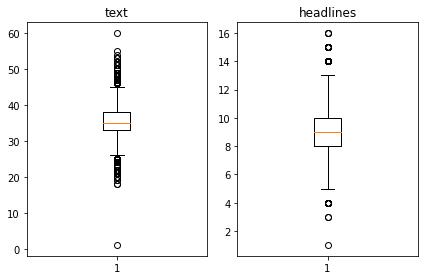

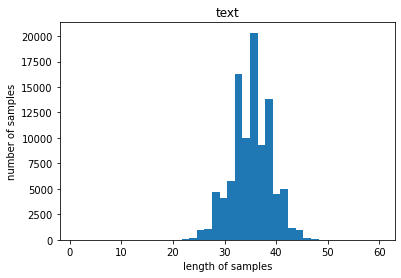

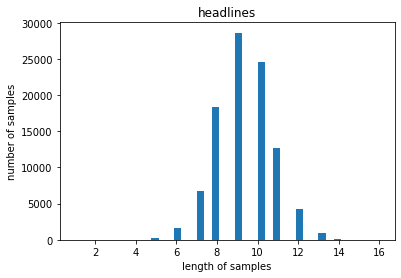

In [16]:
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
#Text의 최대 길이와 Headlines의 적절한 최대 길이 임의로 정하기
text_max_len = 40  #텍스트의 최대 길이
headlines_max_len = 11  #헤드라인의 최대 길이

In [18]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [19]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


약 90%를 웃도는 정도로 확인된다. 이때, 내용이 망가지는 것을 방지하기 위해 정해진 길이보다 길면 제외하도록 하자.

In [20]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 85843


다음으로 시작과 종료 토큰을 추가한다.

In [21]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


토큰이 잘 붙었음을 확인했으니, 인코더/디코더의 입력과 디코더레이블을 numpy로 저장하자

In [22]:
#numpy로 다시 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

이제 Train / Test를 분리하도록 하자

먼저 encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어준다.

In [23]:
# 정수 시퀀스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[21538 81481 21862 ... 47850 83092  3931]


In [24]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

섞인 데이터를 8:2의 비율로 Train / Test로 분리한다.  
전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의하자.

In [25]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17168


In [26]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 68675
훈련 레이블의 개수 : 68675
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


- 단어 집합(vocabulary) 만들기 및 정수 인코딩

각 단어에 고유한 정수를 mapping하는 작업이 필요하다.  
keras의 tokenizer를 사용하여 훈련 데이터에 대해서 단어 집합을 만들어보자.

In [27]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

빈도수가 6번 이하인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자.

In [28]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64602
등장 빈도가 6번 이하인 희귀 단어의 수: 44016
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20586
단어 집합에서 희귀 단어의 비율: 68.13411349493825
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.787242347511922


등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하자.

위에서 이를 제외한 단어 집합의 크기를 약 2만개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 20,000으로 제한한다.

In [29]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [30]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[278, 1304, 1858, 10040, 1166, 4187, 303, 1166, 17979, 1073, 967, 352, 162, 961, 1565, 165, 4616, 14137, 1250, 603, 114, 17979, 1142, 3149, 137, 79, 99, 1387, 350, 316, 2483, 1406, 1268, 811, 172, 1721, 19191], [826, 61, 50, 15, 3502, 1498, 56, 3054, 1574, 1766, 17, 2287, 5864, 3767, 3590, 1260, 13147, 3055, 127, 882, 1121, 9808, 12, 1649, 1498, 6, 3054, 1574, 1766, 11486, 1524, 3767, 271, 1260, 25, 1347, 236, 4892], [3692, 53, 77, 7069, 6550, 1323, 187, 156, 5, 2377, 3302, 7295, 2138, 3692, 53, 1657, 3535, 615, 86, 1359, 156, 6550, 1323, 77, 3565, 3692, 53, 9388, 581, 11487, 4984]]


더 이상 텍스트 데이터가 아니라 정수가 나오고 있다.

Summary 데이터에 대해서도 동일한 작업을 수행하자.

In [31]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [32]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28495
등장 빈도가 5번 이하인 희귀 단어의 수: 18765
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9730
단어 집합에서 희귀 단어의 비율: 65.85365853658537
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.170208756223772


위에서와 같은 이유로, 단어 집합의 크기를 8,000으로 제한해주자.

In [33]:
tar_vocab = 8000  #단어 집합 크기 8000 제한
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 7101, 1147, 495, 697, 10, 226, 3628, 6267, 95, 404], [1, 317, 40, 4442, 2541, 1717, 5, 29, 2433, 1268], [1, 5932, 5647, 1566, 528, 295, 3149, 17, 2381, 35], [1, 14, 60, 471, 4598, 992, 13, 50, 5648], [1, 18, 305, 244, 622, 156, 44, 4136, 622]]
target
decoder  [[7101, 1147, 495, 697, 10, 226, 3628, 6267, 95, 404, 2], [317, 40, 4442, 2541, 1717, 5, 29, 2433, 1268, 2], [5932, 5647, 1566, 528, 295, 3149, 17, 2381, 35, 2], [14, 60, 471, 4598, 992, 13, 50, 5648, 2], [18, 305, 244, 622, 156, 44, 4136, 622, 2]]


In [34]:
#빈 샘플 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 68674
훈련 레이블의 개수 : 68674
테스트 데이터의 개수 : 17168
테스트 레이블의 개수 : 17168


마지막으로 패딩을 넣어주며 전처리를 마무리하자.

In [35]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

---
## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

In [36]:
#함수형 API
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [37]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [38]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      2560000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

어텐션 함수를 이용하여 디코더 출력층을 수정해보자!

In [39]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      2560000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

### 모델 훈련

설계한 모델을 가지고 훈련을 진행해보자.  
Early stopping을 사용하여 검증데이터 loss의 감소가 멈췄을 때, 훈련을 종료하도록 설정했다.

In [40]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
269/269 [==============================] - 153s 517ms/step - loss: 5.8328 - val_loss: 5.4419
Epoch 2/50
269/269 [==============================] - 138s 514ms/step - loss: 5.2885 - val_loss: 5.1100
Epoch 3/50
269/269 [==============================] - 139s 517ms/step - loss: 4.9332 - val_loss: 4.8014
Epoch 4/50
269/269 [==============================] - 139s 518ms/step - loss: 4.6425 - val_loss: 4.6148
Epoch 5/50
269/269 [==============================] - 139s 517ms/step - loss: 4.4266 - val_loss: 4.4626
Epoch 6/50
269/269 [==============================] - 138s 514ms/step - loss: 4.2480 - val_loss: 4.3349
Epoch 7/50
269/269 [==============================] - 139s 518ms/step - loss: 4.0976 - val_loss: 4.2430
Epoch 8/50
269/269 [==============================] - 140s 519ms/step - loss: 3.9628 - val_loss: 4.1753
Epoch 9/50
269/269 [==============================] - 140s 520ms/step - loss: 3.8437 - val_loss: 4.0914
Epoch 10/50
269/269 [==============================] - 140s 519m

Early stopping 덕분에 epoch가 조기 종료되었다!

이제 Train loss와 Validation loss가 줄어드는 과정을 시각화 해서 확인해보자.

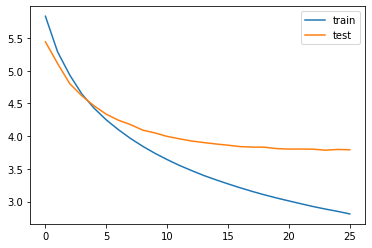

In [41]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.

In [42]:
#텍스트 데이터 복원을 위해 3개 사전 정의
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다.

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했으나,

정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 인퍼런스를 위한 모델 설계를 별도로 해주어야 한다.

이때는 인코더 모델과 디코더 모델을 분리해서 설계하도록 하자.

In [43]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘을 사용하는 출력층을 설계

In [44]:
#어텐션 메커니즘을 사용하는 출력층 설계
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 정의

In [45]:
#인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # 에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

---
## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [46]:
# Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고
# Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들 거예요.

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보자.

In [47]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")
    print("----"*30)

원문 : indian railways ordered use radio frequency identification tags tracking wagons coaches ensure effective transparent functioning tag designed centre railway information system would cost around per tag would enable railways know exact position data currently maintained manually 
실제 요약 : railways to use tags to track coaches 
1/1 [==============================] - 0s 22ms/step
예측 요약 :  railways to use of stations to improve


------------------------------------------------------------------------------------------------------------------------
원문 : war afghanistan caused around civilian casualties first three months year according united nations mission war torn country armed conflict country killed injured civilians suicide improvised explosive devices complex attacks ground leading causes casualties 
실제 요약 : afghan war caused civilian casualties in un 
1/1 [==============================] - 0s 22ms/step
예측 요약 :  afghanistan war war war on war in afghanistan


-------------------

(예전부터 1/1 [==============================] - 0s 20ms/step 이거는 왜 나오는지 모르겠음..)

---
## Step 5. Summa을 이용해서 추출적 요약해보기

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

### Data reload

In [48]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

### Summarize 사용하기
Summa의 summarize()의 인자로 사용되는 값들에 대해서 알아볼게요.

> text (str) : 요약할 테스트.  
> ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값  
> words (int or None, optional) – 출력에 포함할 단어 수. (만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.)  
> split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행해요.  
그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있어요.  
비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여볼게요.  
원문의 0.005%만을 출력하도록 설정했어요.

In [52]:
from summa.summarizer import summarize

In [56]:
for idx, (head, text) in enumerate(zip(data['headlines'], data['text'])):
    if idx == 50:
        break
    print("원문 :", text)
    print("실제 요약 :", head)
    print("추출적 요약 :", summarize(text, ratio=0.5))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출적 요약 : Users get one CRED coin per rupee of bill p

---
## Discussion

결과에 대해서는 공통적으로 어떤 문장은 제대로 요약되기도 했지만 어떤 문장은 엉터리로 요약되었다. 하지만 추출적 요약이 더 정확도가 높았다. 여러개의 출력물이 있지만 결과가 일관적인 특징을 가지고 있으므로 각각 하나의 샘플만 예시로써 추출하여 비교해보려 한다.


---
### - 추상적 요약  
원문 : indian railways ordered use radio frequency identification tags tracking wagons coaches ensure effective transparent functioning tag designed centre railway information system would cost around per tag would enable railways know exact position data currently maintained manually  

실제 요약 : railways to use tags to track coaches  
예측 요약 : railways to use of stations to improve (동사를 포함하지 않는 불완전한 문장이다)

- 추상적 요약은 원문에 없던 문장이라도 핵심 문맥을 반영해 새로운 문장을 생성해 원문을 요약하는 방식이다. 이는 사람이 요약한 것 처럼 보이고, 이는 당연하게도 추출적 요약보다 난이도가 높다.

- 결과적으로 위 샘플의 경우, railways라는 키포인트는 확실하게 짚었지만 문장을 생성해내는 과정에서 올바른 문장을 생성해내는 것을 실패했고, 문법 또한 정확하지 않다. 하지만 원문에는 없는 improve를 생성해 낸 것은 적절한 것이었기에 놀라운 부분이다.

---
### 추출적 요약  
원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.  

실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike  
추출적 요약 : upGrad's Online Power Learning / has powered / 3 lakh+ careers. ( 명사와 동사를 갖는 온전한 문장이다.(/로 표시했음))
- 추출적 요약은 원문에서 중요한 핵심 문장 또는 단어를 뽑아 구성된 요약문을 만드는 방식이다. 이 방식을 통해 만들어진 문장이나 단어는 모두 원문에 있는 문장들이다.
- 따라서 핵심단어를 포함 할 확률이 상대적으로 높고, 문장의 완성도 역시 상대적으로 높다.
- 하지만 그만큼 이미 존재하는 문장이나 단어를 구성하기 때문에 모델의 새로운 언어 표현 능력이 불가하다. 이는 추출적 요약이 가지는 명확한 한계이다.

위 비교를 키워드로 정리하자면 아래와 같다. (물론, 어디까지나 위의 결과물에 대한 상대적인 비교이다.)

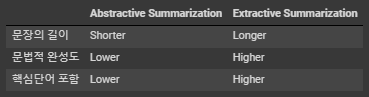

- 정확도와 실제 인간이 인지할 수 있는 정확성 사이의 Gap에 대해서 생각해볼 수 있는 예제였다.
- 프로젝트의 결과로는 추출적 요약이 문법적 완성도나 핵심단어를 포함하는 빈도가 더 높아서 '더 나은'방법 처럼 보였다.
- 하지만 새로운 생성이 없는 방식을 과연 '인공지능스럽다'고 말할 수 있을까?
- 이런 부분에 대한 고찰이 자연어처리가 가지는 매력일 수도 있을 것 같다.
